# Pyglet

In [1]:
import pyglet, time
import numpy as np
import matplotlib.pyplot as plt
from pyglet.gl import *
glEnable(GL_BLEND)
glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)

%cd /Users/millejoh/Documents/GitHub/Islands/
%run worldgen.py
%matplotlib inline

C:\Users\millejoh\Documents\GitHub\Islands


In [2]:
%load_ext autoreload
%autoreload 2

# Pyglet/IPython Integration

Per the 3.x
[documentation](http://ipython.org/ipython-doc/stable/config/eventloops.html)
to integrate an event loop with the kernel (not the terminal) it must occasionally call
[`IPython.kernel.zmq.kernelbase.Kernel.do_one_iteration()`](http://ipython.org/ipython-doc/stable/api/generated/IPython.kernel.zmq.kernelbase.html#IPython.kernel.zmq.kernelbase.Kernel.do_one_iteration).

The decorator `@register_integration(<name>)` will add special semantics to the `%gui <name>` magic.

Wonder if scheduling calls through `pyglet.clock.schedule` will work?

In [3]:
from IPython.kernel.zmq.eventloops import register_integration

def kernel_callback(dt, kernel):
    kernel.do_one_iteration()

@register_integration('pyglet')
def pyglet_event_loop(kernel):
    pyglet.clock.schedule_interval(kernel_callback, 0.1, kernel)
    pyglet.app.run()

C:\Users\millejoh\Miniconda3\envs\py34\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
%gui pyglet

Yes, yes it does. One thing that doesn't seem to work so well, however, is
stopping and restarting the pyglet event loop. As in, doesn't work at all.
Another issue seems to be CPU resource issue. The callback interval could
probably be tweaked to trade off response time vs. cpu usage.

Okay, now can we tweak event handlers while the app is live?

# Graphics

With 2D rougelike text graphics we split the screen into cells, each
cell has a background color, a foreground color, and a glyph. This
does not give a lot of options for displaying information about the world.

A `GlyphSet` 


In [11]:
%run pyglet_grid.py

In [13]:
world_width = 80
world_height = 50 # n x n grid
imsize = 12 # Font is 12x12

worldpx_w, worldpx_h = world_width * imsize, world_height * imsize

# terrain = np.zeros((world_height, world_width))
#im_set = pyglet.image.load('12x12.png')
#im_set_seq  = pyglet.image.ImageGrid(im_set, 48, 16)
# im_set_tex_seq = pyglet.image.TextureGrid(im_set_seq)

gs = GlyphSet('12x12.png', 48, 16)

In [14]:
batch = pyglet.graphics.Batch()

In [15]:
canvas = pyglet.window.Window(worldpx_w, worldpx_h)

Draw a glyph.

In [16]:
glyph0 = gs[0]
glyph1 = gs[0, 1]

glyph0.x, glyph0.y = canvas.width//2, canvas.height//2
glyph0.batch = batch
glyph1.batch = batch

In [17]:
water = pyglet.image.SolidColorImagePattern(color_rgba(keyrgb_color_int[0]))
white = pyglet.image.SolidColorImagePattern((0, 0, 50, 255))
water_square = pyglet.sprite.Sprite(water.create_image(imsize, imsize))
big_white = pyglet.sprite.Sprite(white.create_image(12, 12))

In [18]:
glyph1.x, glyph1.y = 10, 10
@canvas.event
def on_draw():
    canvas.clear()
    water_square.draw()
    big_white.draw()
    batch.draw()

In [19]:
big_white.x, big_white.y = 10, 10

In [ ]:
glyph0.color = (0,50,80)

In [21]:
glyph1.opacity = 255

In [22]:
def update(dt):
    # Move 10 pixels per second
    if glyph1.x > canvas.width:
        glyph1.x = 0
    else:
        glyph1.x += dt * 10

# Call update 60 times a second
pyglet.clock.schedule_interval(update, 1/60.)

In [26]:
glyph0.batch = batch

# Heightmaps

In [27]:
import Heightmap as hm

In [28]:
map = np.ones((50, 50))

In [29]:
hm.add_hill(map, 10, 10, 5, 2)

In [ ]:
hm.dig_hill(map, 30, 30, 5, 2)

In [31]:
fig = plt.imshow(map, origin='lower')
plt.colorbar()

In [10]:
fig

# World Generation

In [11]:
%run worldgen.py

In [12]:
wg = WorldGenerator(100, 100)
print(wg)

In [13]:
wg.generate()

UnboundLocalError: local variable 'max' referenced before assignment

Building heightmap...
Calculating precipitation...


In [34]:
%timeit wg.build_base_map()

1 loops, best of 3: 28.4 s per loop


In [14]:
print(wg._hm[0,1])

0.0591473017522


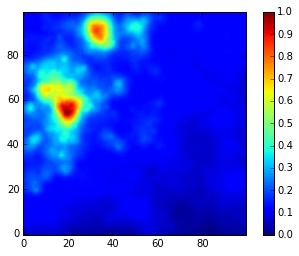

In [15]:
plt.imshow(wg._hm, origin='lower')
plt.colorbar()

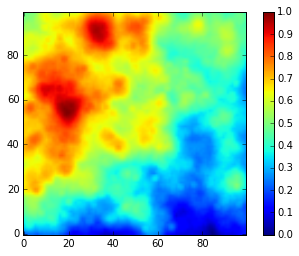

In [16]:
plt.imshow(wg._hm2, origin='lower')
plt.colorbar()

In [ ]:
np.amin(wg._hm)

In [6]:
map = np.arange(25)

In [9]:
map.shape = (5,5)

In [11]:
map

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [26]:
a = map.ravel()

In [31]:
a[0] = 3

In [32]:
map

array([[ 3,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

# Performance Testing

World generation involves lots of looping over numpy arrays, so there
should be plenty of opportunities to use numba/cython (others?) to
optimize. The good and bad of coding on Surface 3 is that performance
debits are accentuated with the Atom processor. It has multi-cores,
though, which numba should be able to take advantage of, right?

First see if numba is actually doing anything on this architecture
using the example from the front page of numbas
[documentation](http://numba.pydata.org/).

In [24]:
from numba import jit
from numpy import arange

In [25]:
# Without numba
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

a = arange(9).reshape(3,3)

print(a)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


In [28]:
%timeit sum2d(a)

10000 loops, best of 3: 36.8 µs per loop


In [27]:
@jit
def sum2d_numba(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

In [35]:
%timeit sum2d_numba(a)

The slowest run took 16.01 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 759 ns per loop


In [ ]:
test_world = WorldGenerator(10,10)

Looks like optimizations are happening - the jit code executes, at best, at 741ns while the not jit code executes 37.2us per loop, not quite two orders of magnitude faster.

Now to find out where the bottleneck is in the world genertion code.
